# 実習6-2
### 音声データをCNNで分類

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from numpy import matlib
from sklearn.model_selection import GroupKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import Model,layers,Input,optimizers
from keras.utils import np_utils
from keras.regularizers import l2,l1
from keras import backend as K
%matplotlib inline

In [2]:
#演習の授業用にdropboxにアップロードしておきましたので、そこからデータセットをダウンロードします
import urllib.request 

url = "https://www.dropbox.com/s/h4mwfjhmv4u1ohr/recordings.zip?dl=1" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "recordings.zip" # recordings.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

('recordings.zip', <http.client.HTTPMessage at 0x7f5069503e80>)

In [3]:
#uploadしたzipファイルを解凍する
import zipfile
with zipfile.ZipFile("recordings.zip","r") as zip_ref:
    zip_ref.extractall("") #""の中にはディレクトリのpathが入る

In [4]:
#フォルダの中の.wavの拡張子がついたものを読み込む
#os.path.isfile(): パスが存在しているファイルであるかどうかを確認する
#andは論理演算子
audio_dir = 'recordings/'
file_names = [f for f in os.listdir(audio_dir) if os.path.isfile(os.path.join(audio_dir, f)) and '.wav' in f]

#話者と正解のラベルを作る(stratifiedKFoldやGroupKFoldとかに必要)
speaker = np.array([i.split('_')[1] for i in file_names])
label = np.array([int(i.split('_')[0]) for i in file_names])

In [5]:
#中身の表示
import pprint
print(speaker)
print(label)
print(file_names)

['jackson' 'theo' 'nicolas' ... 'yweweler' 'yweweler' 'theo']
[0 6 4 ... 8 0 4]
['0_jackson_48.wav', '6_theo_32.wav', '4_nicolas_32.wav', '0_jackson_47.wav', '0_theo_14.wav', '7_jackson_47.wav', '0_jackson_9.wav', '3_theo_16.wav', '1_jackson_21.wav', '4_yweweler_28.wav', '7_theo_1.wav', '0_nicolas_0.wav', '7_yweweler_40.wav', '4_yweweler_1.wav', '5_yweweler_5.wav', '5_yweweler_46.wav', '0_yweweler_11.wav', '0_jackson_23.wav', '9_yweweler_24.wav', '3_yweweler_12.wav', '5_yweweler_34.wav', '7_nicolas_7.wav', '1_nicolas_8.wav', '4_jackson_43.wav', '9_jackson_39.wav', '6_yweweler_8.wav', '0_theo_19.wav', '5_theo_3.wav', '5_yweweler_18.wav', '6_theo_8.wav', '1_yweweler_47.wav', '9_nicolas_35.wav', '4_jackson_0.wav', '0_nicolas_13.wav', '6_theo_13.wav', '1_theo_9.wav', '5_yweweler_20.wav', '5_yweweler_24.wav', '9_nicolas_15.wav', '3_yweweler_37.wav', '9_theo_37.wav', '3_yweweler_48.wav', '1_theo_28.wav', '1_jackson_45.wav', '0_theo_35.wav', '7_jackson_10.wav', '2_nicolas_17.wav', '6_jackson_

## spectrogram→2dCNN

In [6]:
#scipyのsignalを使ってspectrogramを作成する関数 
#データのsample_rateは8kHzつまり8000
#logを取ることでdBスケールになり、弱い信号も見やすくなる
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3)) #160 (8kHzの中で160点のデータなので20ms)
    noverlap = int(round(step_size * sample_rate / 1e3)) #80 (8kHzの中で80点のデータなので10ms)
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann', #窓関数としてハン窓を指定してみる
                                    nperseg=nperseg,
                                    noverlap=noverlap)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps) #.T：転置行列にする

Text(0.5, 0, 'Seconds')

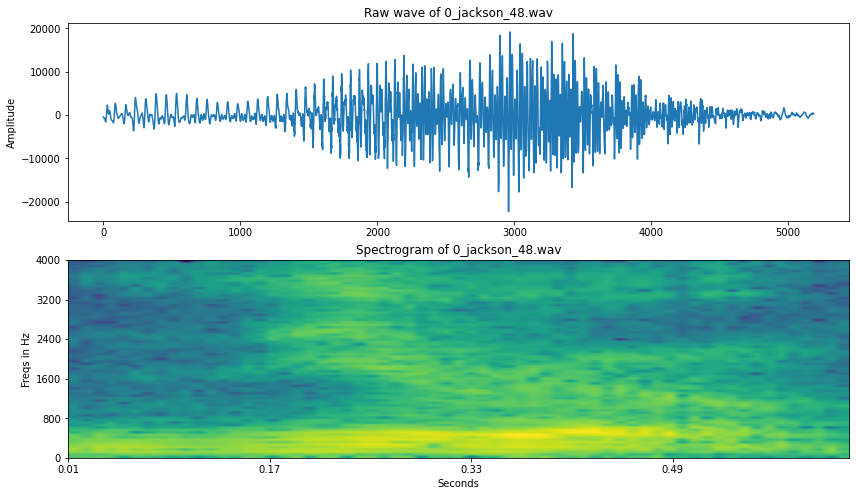

In [7]:
#波形とspectrogramを表示してみる
file_name = file_names[0]
sample_rate,samples = wavfile.read(audio_dir+file_name)
freqs, times, spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))

#画像の表示
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_name)
ax1.set_ylabel('Amplitude')
ax1.plot(np.arange(len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()]) #座標に振るメモリの範囲を左下を原点にして、(xmin,xmax,ymin,ymax)で指定
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file_name)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

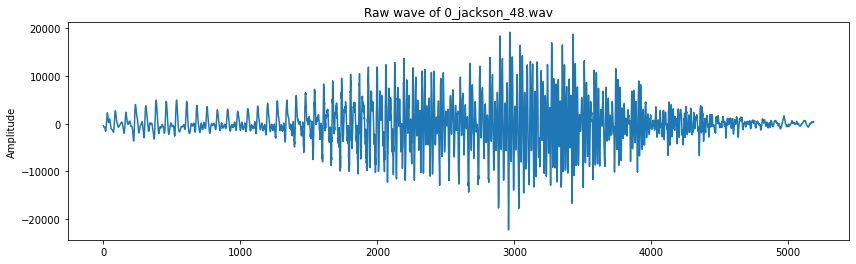

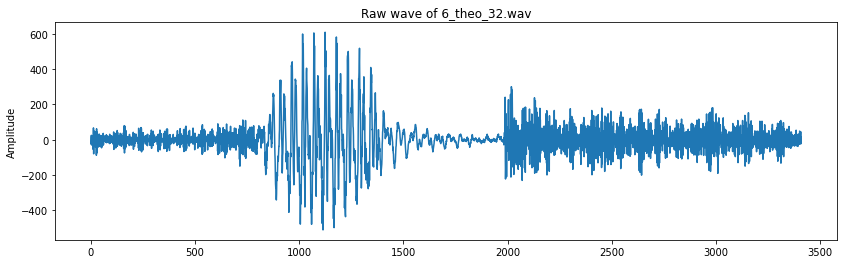

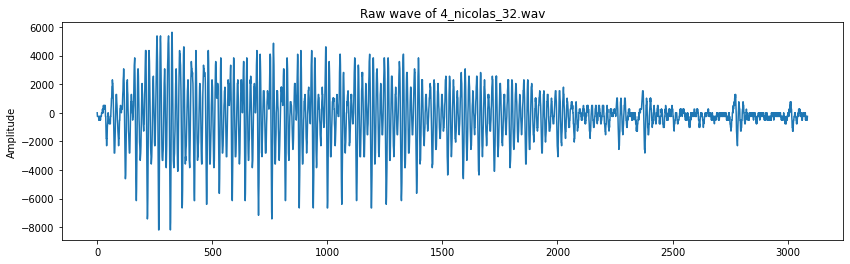

In [8]:
#３つほど抜き出してきて波形表示
for file_name in file_names[:3]:
    sample_rate,samples = wavfile.read(audio_dir+file_name)
    fig,ax = plt.subplots(figsize=(14, 4))
    ax.set_title('Raw wave of ' + file_name)
    ax.set_ylabel('Amplitude')
    ax.plot(np.arange(len(samples)), samples)

### dataによって計測時間が異なる。→　各サンプルを反復させて1秒に合わせてみる

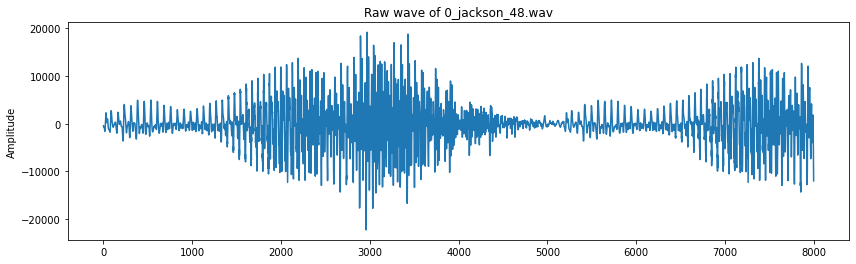

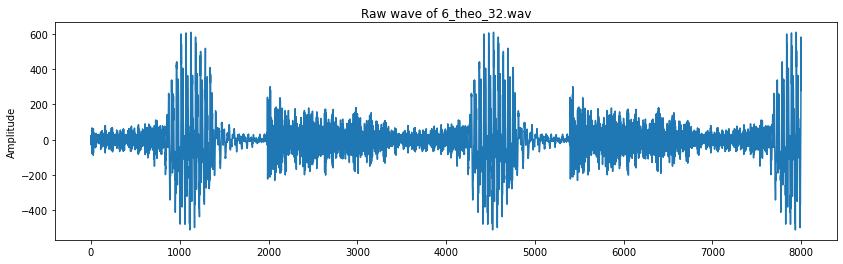

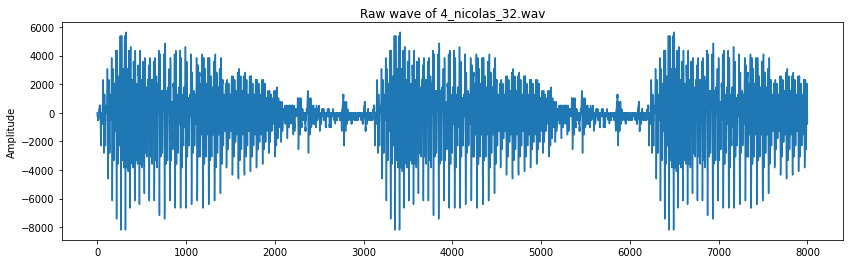

In [9]:
#データを反復させ、1秒分を拾ってくる。Hz = 8000なので8000点
#np.matlib.repmat(A,1,5)でAを1x5回繰り返す。1は列方向、5は行方向。
for file_name in file_names[:3]:
    sample_rate,samples = wavfile.read(audio_dir+file_name)
    extend_samples = np.matlib.repmat(samples,1,int(8000//samples.shape[0]+1))[:,:8000]
    extend_samples = np.squeeze(extend_samples) #大きさが1の次元を全部除去した配列を返す (1, 8000) ->(8000)
    fig,ax = plt.subplots(figsize=(14, 4))
    ax.set_title('Raw wave of ' + file_name)
    ax.set_ylabel('Amplitude')
    ax.plot(np.arange(8000), extend_samples) #引数どちらのshapeも(8000)

In [10]:
#ファイルをすべて読み込み、spectrogramを作る。
T = []
spec = []
for file_name in file_names:
    sample_rate,samples = wavfile.read(audio_dir+file_name)
    freq, times, spectrogram = log_specgram(samples,sample_rate)
    T.append(times)
    spec.append(spectrogram)
spec = np.array(spec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [11]:
#np.whereで発話時間が1秒を超えているものを見つける。今回は1秒に揃えようと思うのでこれらのデータは取り除く。
del_sample = np.where(np.array([i.max() for i in T])>1)[0]
spec = np.delete(spec,del_sample,0)
speaker = np.delete(speaker,del_sample,0)
label = np.delete(label,del_sample,0)

In [12]:
#specのデータを反復させ、最初から100点を拾ってくる。窓関数が１０mステップなので、１００点で1秒分。
#さらに、データの正規化を短い区切り（以下では２５点ずつ）に区切り正規化することにより、
#単語の長さによる平均の変化をなくす。https://qiita.com/daimonji-bucket/items/c61c19f25deeceec47d8

tr  = np.array([np.matlib.repmat(i,int(100//i.shape[0]+1),1)[:100,:] for n,i in enumerate(spec)])
train = []

for i in tqdm_notebook(tr):
    for k in range(int(i.shape[0]/25)):
        chunk = i[25*k:25*k+25,:]
        i[25*k:25*k+25,:] = (chunk-chunk.mean(axis = 0))/chunk.std(axis = 0) #正規化
    train.append(i.T) #行方向に周波数、列方向に時間軸
train = np.array(train).reshape(-1,81,100,1) #81は周波数方向のサイズ、１００は時間方向のサイズ


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [13]:
#model

def se_block(In, channels, r=8):
    # Squeeze
    x = layers.GlobalAveragePooling2D()(In)
    # Excitation
    x = layers.Dense(channels//r, activation="relu")(x)
    x = layers.Dense(channels, activation="sigmoid")(x)
    return layers.Multiply()([In, x])

def make_model_logmel():
    input_tensor = Input(shape = (81,100,1))
    x = layers.Conv2D(64,(3,7),activation='relu',padding='same')(input_tensor)
    x = se_block(x,64,8)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,1))(x)
    x = layers.Conv2D(128,(7,1),activation='relu',padding='same')(x)
    x = se_block(x,128,8)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((4,1))(x)
    x = layers.Conv2D(256,(10,1),activation='relu')(x)
    x = se_block(x,256,8)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512,(1,7),activation = 'relu',padding='same')(x)
    x = se_block(x,512,8)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256,activation ='relu')(x)
    x = layers.BatchNormalization()(x)
    pred = layers.Dense(10,activation = 'softmax',kernel_regularizer=l2(.0005))(x)
    model = Model(input_tensor,pred)
    return model

def image_generator():
    """ ディレクトリ内の画像を読み込んでトレーニングデータとバリデーションデータの作成する場合に使う """
    train_datagen = ImageDataGenerator()
    validation_datagen = ImageDataGenerator()
    return (train_datagen, validation_datagen)

#learning rate をコサイン関数的に減少させるのに使います。
def step_decay(epoch): 
    base_lr = 0.05
    return base_lr*(np.cos((epoch/epoch_size)*np.pi) +1)/2


#F値を求める
from sklearn.metrics import f1_score
from keras.callbacks import Callback

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon()) #precision
    r = tp / (tp + fn + K.epsilon()) #recall

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

epoch_size = 30
batch_size = 64

In [14]:
(train_x, val_x, train_y, val_y) = train_test_split(train, label, test_size=0.2, random_state=0)

callback_list = [LearningRateScheduler(step_decay), #LearningRateSchedulerを使ってstep_decayを実装
                keras.callbacks.ModelCheckpoint(filepath= '2dmodel.h5',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)] #最もlossが低い時の重みを2dmodel.h5という名前で保存

train_y = np_utils.to_categorical(train_y)
val_y = np_utils.to_categorical(val_y)

model = make_model_logmel()
train_datagen,validation_datagen = image_generator()

model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=0.05, momentum=0.9),
          metrics=['accuracy',f1])

hist = model.fit_generator(train_datagen.flow(train_x, train_y, batch_size=64),
                    steps_per_epoch=train_x.shape[0]//64,
                    validation_data=validation_datagen.flow(val_x,val_y, batch_size=64),
                    validation_steps=val_x.shape[0]//64,
                    epochs=30, callbacks=callback_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
24/24 [==============================] - 12s 137ms/step - loss: 2.3531 - accuracy: 0.2602 - f1: 0.1689 - val_loss: 5.6760 - val_accuracy: 0.1380 - val_f1: 0.0614

Epoch 00001: val_loss improved from inf to 5.67604, saving model to 2dmodel.h5
Epoch 2/30
24/24 [==============================] - 2s 101ms/step - loss: 0.8549 - accuracy: 0.7274 - f1: 0.6875 - val_loss: 2.0146 - val_accuracy: 0.4036 - val_f1: 0.3113

Epoch 00002: val_loss improved from 5.67604 to 2.01462, saving model to 2dmodel.h5
Epoch 3/30
24/24 [==============================] - 2s 101ms/step - loss: 0.3571 - accuracy: 0.8725 - f1: 0.8645 - val_loss: 1.3373 - val_accuracy: 0.5755 - val_f1: 0.5127

Epoch 00003: val_loss improved from 2.01462 to 1.33725, saving model to 2dmodel.h5
Epoch 4/30
24/24 [==============================] - 2s 101ms/step - loss: 0.2198 - accuracy: 0.9190 - f1: 0.9031 - val_loss: 0.6556 - val_accuracy: 0.7865 - val_f1: 0.7111

Epoch 00004: val_loss improved from 1.33725 to 0.65565, saving

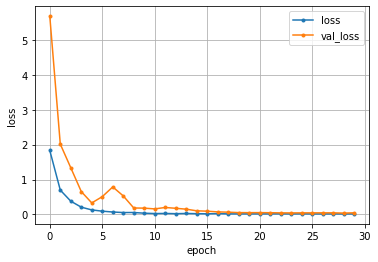

In [15]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.plot(range(30), loss, marker='.', label='loss')
plt.plot(range(30), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

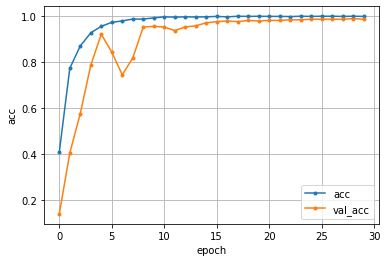

In [16]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# accuracyのグラフ
plt.plot(range(30), acc, marker='.', label='acc')
plt.plot(range(30), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

### 課題7-1
####  実習では2D CNNを使って分類を行いましたが、以下の1D CNNを使って分類を行ってみましょう。


## 1dCNN

In [17]:
#2dと同様に、反復させて最初から8000点分取ってきます。
samples = []
for file_name in file_names:
    sample_rate,sample = wavfile.read(audio_dir+file_name)
    samples.append(sample)
train = np.array([np.matlib.repmat(k,1,int(8000//k.shape[0]+1))[:,:8000].T for k in samples])

In [18]:
def make_model_1d():
    input_tensor = Input(shape = (8000,1))
    x = layers.Conv1D(64,400,activation='relu',padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(128,200,activation='relu',padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(256,100,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Conv1D(256,50,activation = 'relu',padding='same')(x)
    #x = layers.BatchNormalization()(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    pred = layers.Dense(10,activation = 'softmax',kernel_regularizer=l2(.0005))(x)
    model = Model(input_tensor,pred)
    return model

In [20]:
(train_x, val_x, train_y, val_y) = train_test_split(train, y, test_size=0.2, random_state=0)

callback_list = [LearningRateScheduler(step_decay),
            keras.callbacks.ModelCheckpoint(
            filepath= '1dmodel.h5',
            monitor='val_loss',
            save_best_only=True)]

train_y = np_utils.to_categorical(train_y)
val_y = np_utils.to_categorical(val_y)

model = make_model_1d()
train_datagen,validation_datagen = image_generator()

model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(lr=0.05, momentum=0.9),
          metrics=['accuracy',f1])

model.fit(train_x,train_y,batch_size = 64,validation_data=[val_x,val_y],epochs=30, callbacks=callback_list)

ValueError: ignored